In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import awkward as ak
import seaborn as sn

In [80]:
n_dims = [4]
M_min = [10]

BH_labels = [""]*(len(n_dims)*len(M_min))
i = 0
for n in n_dims:
    for M in M_min:
        BH_labels[i] = f"BH_n{n}_M{M}"
        i=i+1
BH_data_paths = [f"/disk/atlas3/data_MC/delphes/{label}_1000events.root:Delphes" for label in BH_labels]

sph_data_paths = ["/disk/atlas3/data_MC/delphes/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_1000events.root:Delphes"]
sph_labels = ["SPH_9TeV"]

N_events = 1000
n_BH_labels = len(BH_data_paths)
n_sph_labels = len(sph_data_paths)

These are some examples of how to look at root files using uproot and awkward arrays. More info in this tutorial:
https://hub.gke2.mybinder.org/user/jpivarski-2020--ep2020-tutorial-7h7oraqf/lab/tree/tutorial.ipynb


In [81]:
#Open file in with-function will close it when you exit
def load_data(rootfile:str, branch:str, keys:list):
    with uproot.open(rootfile) as file:
        valid_list = [key in file.keys() for key in keys]
        if valid_list:
            arr = file[branch].arrays(keys, library="ak", how="zip")[0:N_events]
            return arr[branch]
        else:
            print(keys[not(valid_list)], " not present in data.")

def get_arrays(data_paths):
    clusters = [load_data(path, "Tower", 
                            ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Tower.E"])
                            for path in data_paths]

    jets = [load_data(path, "Jet", 
                            ["Jet.PT", "Jet.Eta", "Jet.Phi"])
                            for path in data_paths]
                
    met = [load_data(path, "MissingET", 
                            ["MissingET.MET", "MissingET.Eta", "MissingET.Phi"])
                            for path in data_paths]

    electrons = [load_data(path, "Electron", 
                            ["Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.Charge"])
                            for path in data_paths]

    muons = [load_data(path, "Muon", 
                            ["Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.Charge"])
                            for path in data_paths]

    photons = [load_data(path, "Photon", 
                            ["Photon.PT", "Photon.Eta", "Photon.Phi"])
                            for path in data_paths]

    return clusters, jets, met, electrons, muons, photons

BH_clusters, BH_jets, BH_met, BH_electrons, BH_muons, BH_photons = get_arrays(BH_data_paths)
sph_clusters, sph_jets, sph_met, sph_electrons, sph_muons, sph_photons = get_arrays(sph_data_paths)

print([len(BH_clusters[i][0]) for i in range(len(BH_clusters))])
print([len(BH_clusters[i]) for i in range(len(BH_clusters))])

[281]
[1000]


# Jet data

In [82]:
#Extracting data for plotting from jets
def jet_data (jets):
    jets = [ak.pad_none(item, 1, axis=-1) for item in jets]
    n_jets = [np.array([len(event) for event in item.PT]) for item in jets]
    jet1_PT = [ak.to_list(item.PT[:,0]/1000) for item in jets]
    jet1_eta = [ak.to_list(item.Eta[:,0]) for item in jets]
    #jet_1_phi = [ak.to_list(item.Phi[:,0]) for item in jets]
    return jets, n_jets, jet1_PT, jet1_eta

BH_jets, n_BH_jets, BH_jet1_PT, BH_jet1_eta = jet_data(BH_jets)
sph_jets, n_sph_jets, sph_jet1_PT, sph_jet1_eta = jet_data(sph_jets)


In [83]:
#sn.set_palette("Paired", int(n_BH_labels + n_sph_labels))
sn.set_theme(context="notebook", style="white", palette="Paired", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
line_styles = ["-", "--", "-", "--", "-", "--"]
sph_colors = ["#fc8d59"]#, "#b30000"]

Text(0.5, 1.0, 'First jet $\\eta$, KDE')

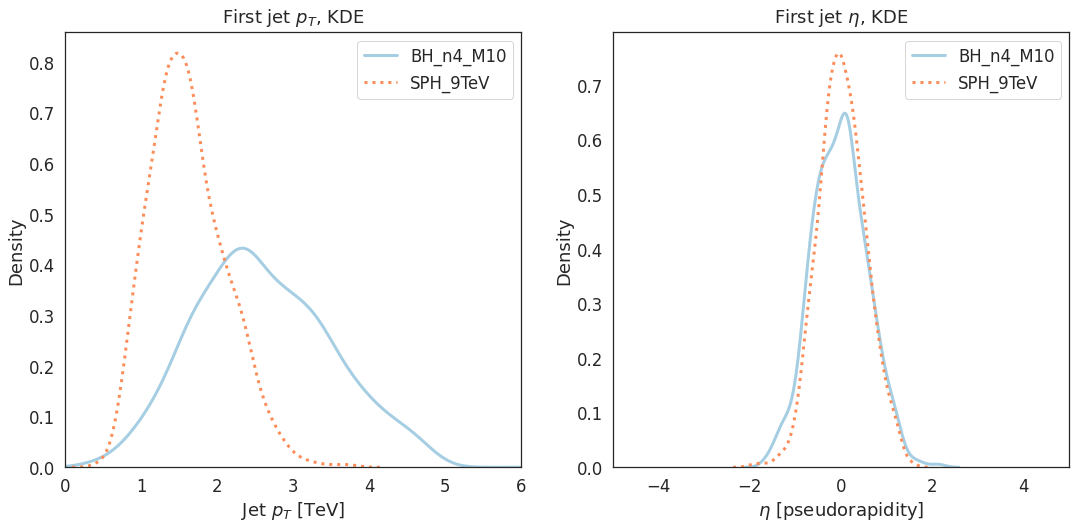

In [84]:
#jet information
fig, ax = plt.subplots(ncols=2, figsize=(18,8))
#sn.histplot(dict(zip(labels, jet_1_PT)), ax = ax[1], bins=50, binrange=[-5, 5], multiple="layer", stat="count")
for i in range(n_BH_labels):
    sn.kdeplot(BH_jet1_PT[i], ls=line_styles[i], label=BH_labels[i], linewidth=3, ax = ax[0])
for i in range(n_sph_labels):
    sn.kdeplot(sph_jet1_PT[i], ls='dotted', linewidth=3, label=sph_labels[i], ax = ax[0], color=sph_colors[i])

ax[0].legend()
ax[0].set_xlabel(r"Jet $p_{T}$ [TeV]")
ax[0].set_xlim(0, 6)
ax[0].set_title(r"First jet $p_{T}$, KDE", pad=10)

#sn.histplot(dict(zip(labels, jet_1_eta)), ax = ax[1], bins=50, binrange=[-5, 5], multiple="layer", stat="count")
for i in range(n_BH_labels):
    sn.kdeplot(BH_jet1_eta[i], ls=line_styles[i], label=BH_labels[i], linewidth=3, ax = ax[1])
for i in range(n_sph_labels):
    sn.kdeplot(sph_jet1_eta[i], ls='dotted', label=sph_labels[i], ax = ax[1], linewidth=3, color=sph_colors[i])

ax[1].legend()
ax[1].set_xlabel(r"$\eta$ [pseudorapidity]")
ax[1].set_xlim(-5, 5)
ax[1].set_title(r"First jet $\eta$, KDE", pad=10)

# Multiplicity plots

In [85]:
#Extracting data for plotting from particle data
def multiplicity(photons, electrons, muons):
    n_photons = [[len(event) for event in item.PT] for item in photons]
    n_electrons = [[len(event) for event in item.PT] for item in electrons]
    #separate muons by charge
    muons_neg = [item[item.Charge < 0] for item in muons]
    muons_pos = [item[item.Charge > 0] for item in muons]
    n_muons_neg = [np.array([len(event) for event in item.PT]) for item in muons_neg]
    n_muons_pos = [np.array([len(event) for event in item.PT]) for item in muons_pos]
    n_muons = [np.array([len(event) for event in item.PT]) for item in muons]
    return n_photons, n_electrons, n_muons_neg, n_muons_pos, n_muons 

n_BH_photons, n_BH_electrons, n_BH_muons_neg, n_BH_muons_pos, n_BH_muons = multiplicity(BH_photons, BH_electrons, BH_muons)
n_sph_photons, n_sph_electrons, n_sph_muons_neg, n_sph_muons_pos, n_sph_muons = multiplicity(sph_photons, sph_electrons, sph_muons)


[]

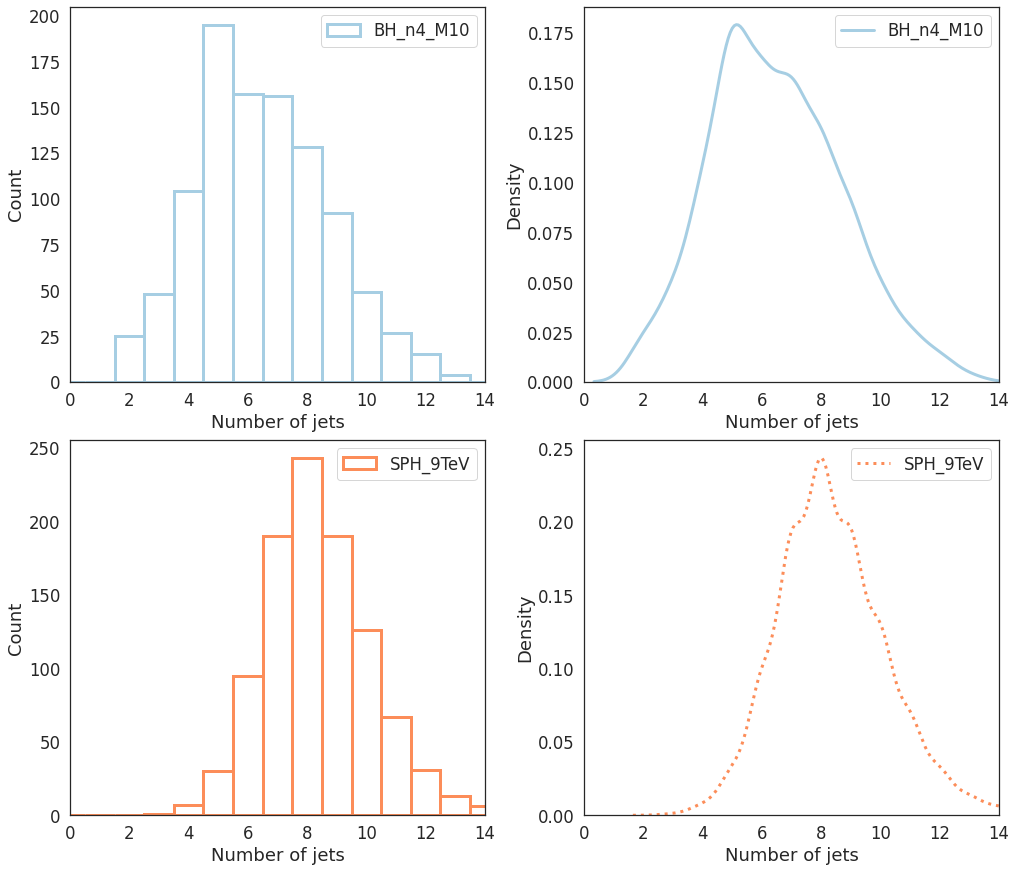

In [86]:
#jet multiplicity
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12), layout="constrained")
#fig.tight_layout(pad=2)
#fig.suptitle("Jet multiplicity", size=20, fontweight="bold")
sn.histplot(dict(zip(BH_labels, n_BH_jets)), ax = ax[0][0], binwidth=1.0, binrange=[-0.5, 14.5], 
            multiple="layer", stat="count", linewidth=3, fill=False)
sn.histplot(dict(zip(sph_labels, n_sph_jets)), ax = ax[1][0], binwidth=1.0, binrange=[-0.5, 14.5], 
            multiple="layer", stat="count", palette=sph_colors, linewidth=3, fill=False)

#sn.histplot(dict(zip(labels, jet_1_eta)), ax = ax[1], bins=50, binrange=[-5, 5], multiple="layer", stat="count")
for i in range(n_BH_labels):
    sn.kdeplot(n_BH_jets[i], ls=line_styles[i], label=BH_labels[i], clip=(0, 14), linewidth=3, ax = ax[0][1])
ax[0][1].legend()
for i in range(n_sph_labels):
    sn.kdeplot(n_sph_jets[i], ls='dotted', label=sph_labels[i], clip=(0, 14), ax = ax[1][1], linewidth=3, color=sph_colors[i])
ax[1][1].legend()

for axis in ax.reshape(-1):
    axis.set_xlabel("Number of jets")
    #axis.set_title("Jet multiplicity")
    axis.set_xlim(0, 14)

plt.plot()

[]

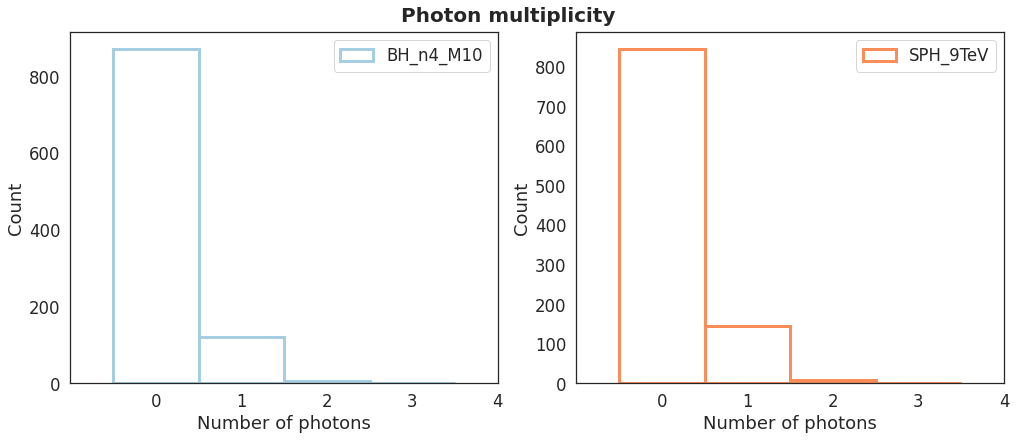

In [87]:
#photon multiplicity
fig, ax = plt.subplots(ncols=2, figsize=(14, 6), layout="constrained")
#fig.tight_layout(pad=2)
fig.suptitle("Photon multiplicity", size=20, fontweight="bold")
sn.histplot(dict(zip(BH_labels, n_BH_photons)), ax = ax[0], binwidth=1.0, binrange=[-0.5, 3.5], 
            multiple="layer", stat="count", linewidth=3, fill=False)
sn.histplot(dict(zip(sph_labels, n_sph_photons)), ax = ax[1], binwidth=1.0, binrange=[-0.5, 3.5], 
            multiple="layer", stat="count", linewidth=3, palette=sph_colors, fill=False)

for axis in ax.reshape(-1):
    axis.set_xlabel("Number of photons")
    #axis.set_title("Jet multiplicity")
    axis.set_xlim(-1, 4)
    axis.set_xticks([0,1,2,3,4])

plt.plot()

In [88]:
#muon multiplicity

def make_data(counts, labels, n_models, n_counts):
    data = [[0]*n_counts]*n_models
    for i in range(0, n_models):
        data[i] = [labels[i]] + list(counts[i])
        
        while(len(data[i]) <= n_counts):
            data[i] = data[i] + [0]
        sum_muons = np.sum([data[i][k]*(k-1) for k in range(1, n_counts)])
        data[i] = data[i] + [sum_muons]
    return data

def make_table(n_muons, labels, n_labels, type):
    count_mu = [np.unique(item, return_counts=True)[1] for item in n_muons]

    col_names = ["Model", "0", "1", "2", "3", "4", f'Total {type}']
    n_counts = 5 #can be dynamically coded, but should not be more than 4 muons
    
    data_mu = make_data(count_mu, labels, n_labels, n_counts)
    df = pd.DataFrame(data_mu, columns=col_names)
    return df

BH_mu_neg = make_table(n_BH_muons_neg, BH_labels, n_BH_labels, 'μ-')
print("The number of muons in each event in the black hole models")
BH_mu_neg

The number of muons in each event in the black hole models


,Model,0,1,2,3,4,Total μ-
0,BH_n4_M10,924,74,2,0,0,78


In [89]:
sph_mu_neg = make_table(n_sph_muons_neg, sph_labels, n_sph_labels, "μ-")
print("The number of muons in each event in the sphaleron models")
sph_mu_neg

The number of muons in each event in the sphaleron models


,Model,0,1,2,3,4,Total μ-
0,SPH_9TeV,934,63,3,0,0,69


In [90]:
BH_mu_pos = make_table(n_BH_muons_pos, BH_labels, n_BH_labels, "μ+")
print("The number of anti-muons in each event in the black hole models")
BH_mu_pos

The number of anti-muons in each event in the black hole models


,Model,0,1,2,3,4,Total μ+
0,BH_n4_M10,874,123,3,0,0,129


In [91]:
sph_mu_pos = make_table(n_sph_muons_pos, sph_labels, n_sph_labels, "μ+")
print("The number of anti-muons in each event in the sphaleron models")
sph_mu_pos

The number of anti-muons in each event in the sphaleron models


,Model,0,1,2,3,4,Total μ+
0,SPH_9TeV,597,388,15,0,0,418


In [92]:
BH_mu = make_table(n_BH_muons, BH_labels, n_BH_labels, "μ- and μ+")
print("The total number of muons + anti-muons in each event in the black hole models")
BH_mu

The total number of muons + anti-muons in each event in the black hole models


,Model,0,1,2,3,4,Total μ- and μ+
0,BH_n4_M10,820,154,25,1,0,207


In [93]:
sph_mu = make_table(n_sph_muons,sph_labels, n_sph_labels, "μ- and μ+")
print("The total number of muons + anti-muons in each event in the sphaleron models")
sph_mu

The total number of muons + anti-muons in each event in the sphaleron models


,Model,0,1,2,3,4,Total μ- and μ+
0,SPH_9TeV,559,400,36,5,0,487


In [94]:
#Asymmetry
BH_asymmetry = []
sph_asymmetry = []

def asymmetry(pos, neg, total):
    idx = np.flatnonzero(total)
    pos, neg, total = pos[idx], neg[idx], total[idx]
    result = (pos-neg)/total
    return(result)

for i in range(n_BH_labels):
    BH_asymmetry.append(asymmetry(n_BH_muons_pos[i], n_BH_muons_neg[i], n_BH_muons[i]))

for i in range(n_sph_labels):
    sph_asymmetry.append(asymmetry(n_sph_muons_pos[i], n_sph_muons_neg[i], n_sph_muons[i]))



[]

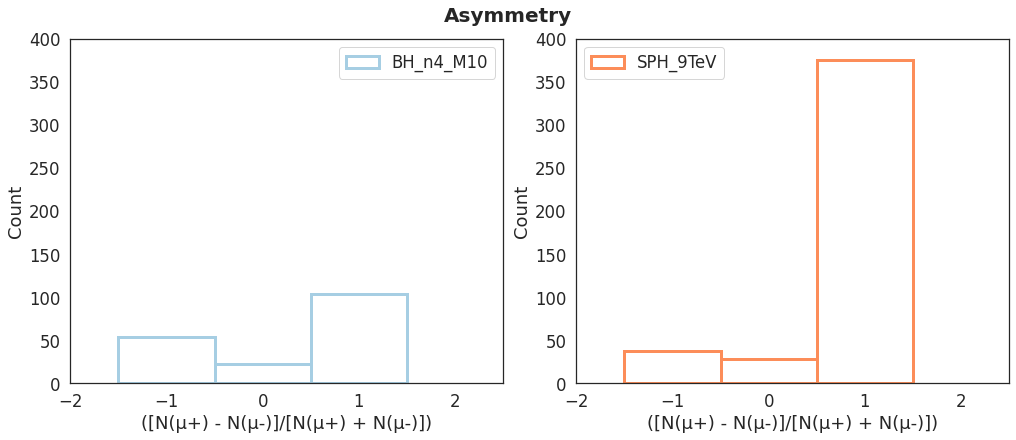

In [95]:
#Asymmetry
fig, ax = plt.subplots(ncols=2, figsize=(14, 6), layout="constrained")
#fig.tight_layout(pad=2)
fig.suptitle("Asymmetry", size=20, fontweight="bold")
sn.histplot(dict(zip(BH_labels, BH_asymmetry)), ax = ax[0], binwidth=1, binrange=[-1.5, 1.5], 
            multiple="layer", stat="count", linewidth=3, fill=False)
sn.histplot(dict(zip(sph_labels, sph_asymmetry)), ax = ax[1], binwidth=1, binrange=[-1.5, 1.5],  
            multiple="layer", stat="count", linewidth=3, palette=sph_colors, fill=False)

for axis in ax.reshape(-1):
    axis.set_xlabel(r"([N(μ+) - N(μ-)]/[N(μ+) + N(μ-)])")
    #axis.set_title("Jet multiplicity")
    axis.set_xlim(-2, 2.5)
    axis.set_ylim(0, 400)
    #axis.set_xticks([0,1,2,3,4])

plt.plot()

In [96]:
#ST = scalar sum of all jets, leptons, photons and MET
def calculate_ST(n_labels, jets, muons, electrons, photons, met):
    ST = np.zeros((n_labels, N_events))
    for i in range(n_labels):
        jet_sum = np.sum(jets[i].PT, axis=-1)/1000
        muon_sum = np.sum(muons[i].PT, axis=-1)/1000
        electron_sum = np.sum(electrons[i].PT, axis=-1)/1000
        photon_sum = np.sum(photons[i].PT, axis=-1)/1000
        met_sum = np.sum(met[i].MET, axis=-1)/1000
        ST[i] = jet_sum + muon_sum + electron_sum + photon_sum + met_sum
    return ST
BH_ST = calculate_ST(n_BH_labels, BH_jets, BH_muons, BH_electrons, BH_photons, BH_met)
sph_ST = calculate_ST(n_sph_labels, sph_jets, sph_muons, sph_electrons, sph_photons, sph_met)

(0.0, 17.0)

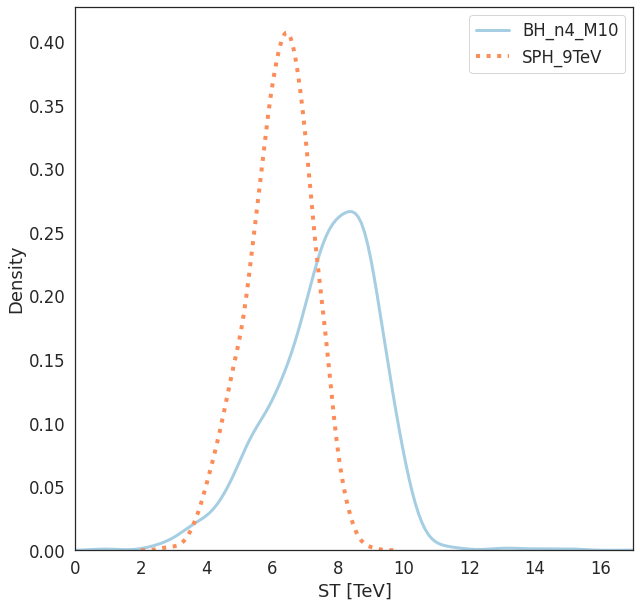

In [97]:
#jet information
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
for i in range(n_BH_labels):
    sn.kdeplot(BH_ST[i], label=BH_labels[i], linestyle=line_styles[i], linewidth=3, ax = ax)
for i in range(n_sph_labels):
    sn.kdeplot(sph_ST[i], label=sph_labels[i], linestyle="dotted", linewidth=4, ax = ax, color=sph_colors[i])

ax.legend()
ax.set_xlabel(r"ST [TeV]")
ax.set_xlim(0, 17)


[]

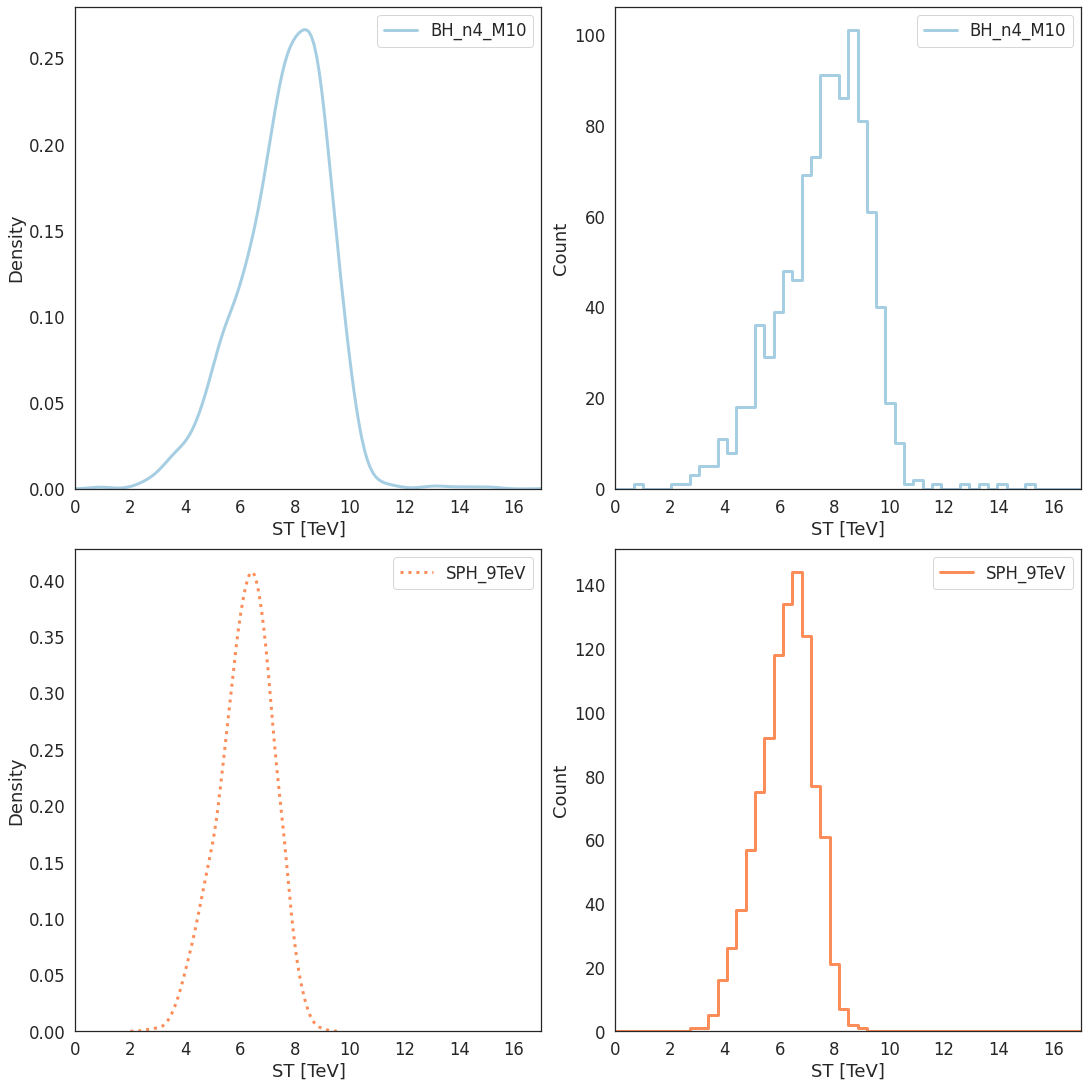

In [98]:
#ST plots

fig, ax = plt.subplots(ncols=2, nrows = 2, figsize=(15,15), layout="constrained")
#fig.suptitle("ST", size=18, fontweight="bold")

for i in range(n_BH_labels):
    sn.kdeplot(BH_ST[i], label=BH_labels[i], linestyle=line_styles[i], linewidth=3, ax = ax[0][0])
ax[0][0].legend()

for i in range(n_sph_labels):
    sn.kdeplot(sph_ST[i], label=sph_labels[i], linestyle="dotted", linewidth=3, ax = ax[1][0], color=sph_colors[i])
ax[1][0].legend()

sn.histplot(dict(zip(BH_labels, BH_ST)), ax = ax[0][1], bins=50, binrange=[0, 17], 
            multiple="layer", stat="count", element="step", linewidth=3, palette="Paired", fill=False)

sn.histplot(dict(zip(sph_labels, sph_ST)), ax = ax[1][1], bins=50, binrange=[0, 17], 
            multiple="layer", stat="count", element="step", linewidth=3, palette=sph_colors, fill=False)

for axis in ax.reshape(-1):
    axis.set_xlabel("ST [TeV]")
    axis.set_xlim(0, 17)
plt.plot()

# Tower plots

In [99]:
#Pad Tower data
max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in BH_clusters])
clusters = [ak.pad_none(item, max_hits, axis=-1) for item in BH_clusters]

max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in sph_clusters])
clusters = [ak.pad_none(item, max_hits, axis=-1) for item in sph_clusters]

In [100]:
#Extracting data for plotting from clusters
#Gets the highest energy + position for each type of calorimeter as well as total transverse energy. 
#These do not necessarily correspond to the same angular position in the detector.
def get_values(item, energy_key):
    largest = ak.argmax(item[energy_key], axis=-1, keepdims=True)
    energy = ak.to_list(ak.flatten(item[energy_key][largest]))
    eta = ak.to_list(ak.flatten(item["Eta"][largest]))
    phi = ak.to_list(ak.flatten(item["Phi"][largest]))
    return energy, phi, eta

def calorimeter_values(clusters, N_events):
    cal_keys = ["ET", "Ehad", "Eem"]
    calorimeter = dict(zip(cal_keys, np.zeros((len(cal_keys), len(clusters), N_events))))
    for key in cal_keys:
        values = [get_values(item, key) for item in clusters]
        energy = [item[0] for item in values]
        phi = [item[1] for item in values]
        eta = [item[2] for item in values]
        calorimeter[key] = [energy, phi, eta]
    
    return calorimeter

BH_cal = calorimeter_values(BH_clusters, N_events)
sph_cal = calorimeter_values(sph_clusters, N_events)

STACKED histograms


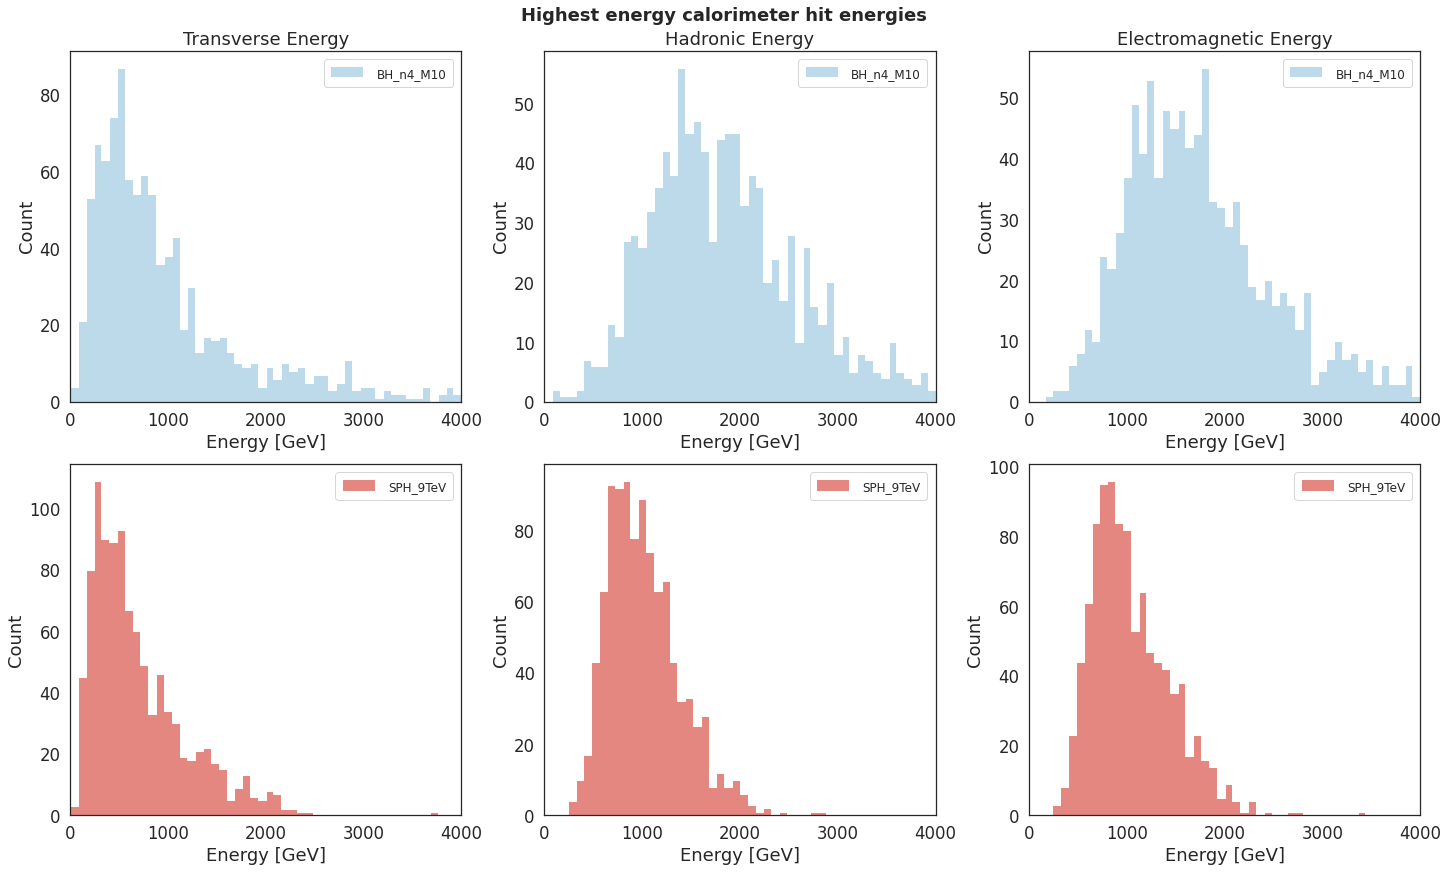

In [101]:
#Energy distribution
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,12), layout="constrained")
fig.suptitle("Highest energy calorimeter hit energies", size=18, fontweight="bold")

sn.histplot(dict(zip(BH_labels, BH_cal["Eem"][0])), ax = ax[0][0], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(sph_labels, sph_cal["Eem"][0])), ax = ax[1][0], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][2].set_title("Electromagnetic Energy")


sn.histplot(dict(zip(BH_labels, BH_cal["Ehad"][0])), ax = ax[0][1], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(sph_labels, sph_cal["Ehad"][0])), ax = ax[1][1], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][1].set_title("Hadronic Energy")


sn.histplot(dict(zip(BH_labels, BH_cal["ET"][0])), ax = ax[0][2], bins=50, binrange=(0, 4000), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(sph_labels, sph_cal["ET"][0])), ax = ax[1][2], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][0].set_title("Transverse Energy")


for axis in ax.reshape(-1):
    axis.set_xlabel("Energy [GeV]")
    axis.set_xlim(0, 4000)
    plt.setp(axis.get_legend().get_texts(), fontsize='12')

print("STACKED histograms")

STACKED histograms


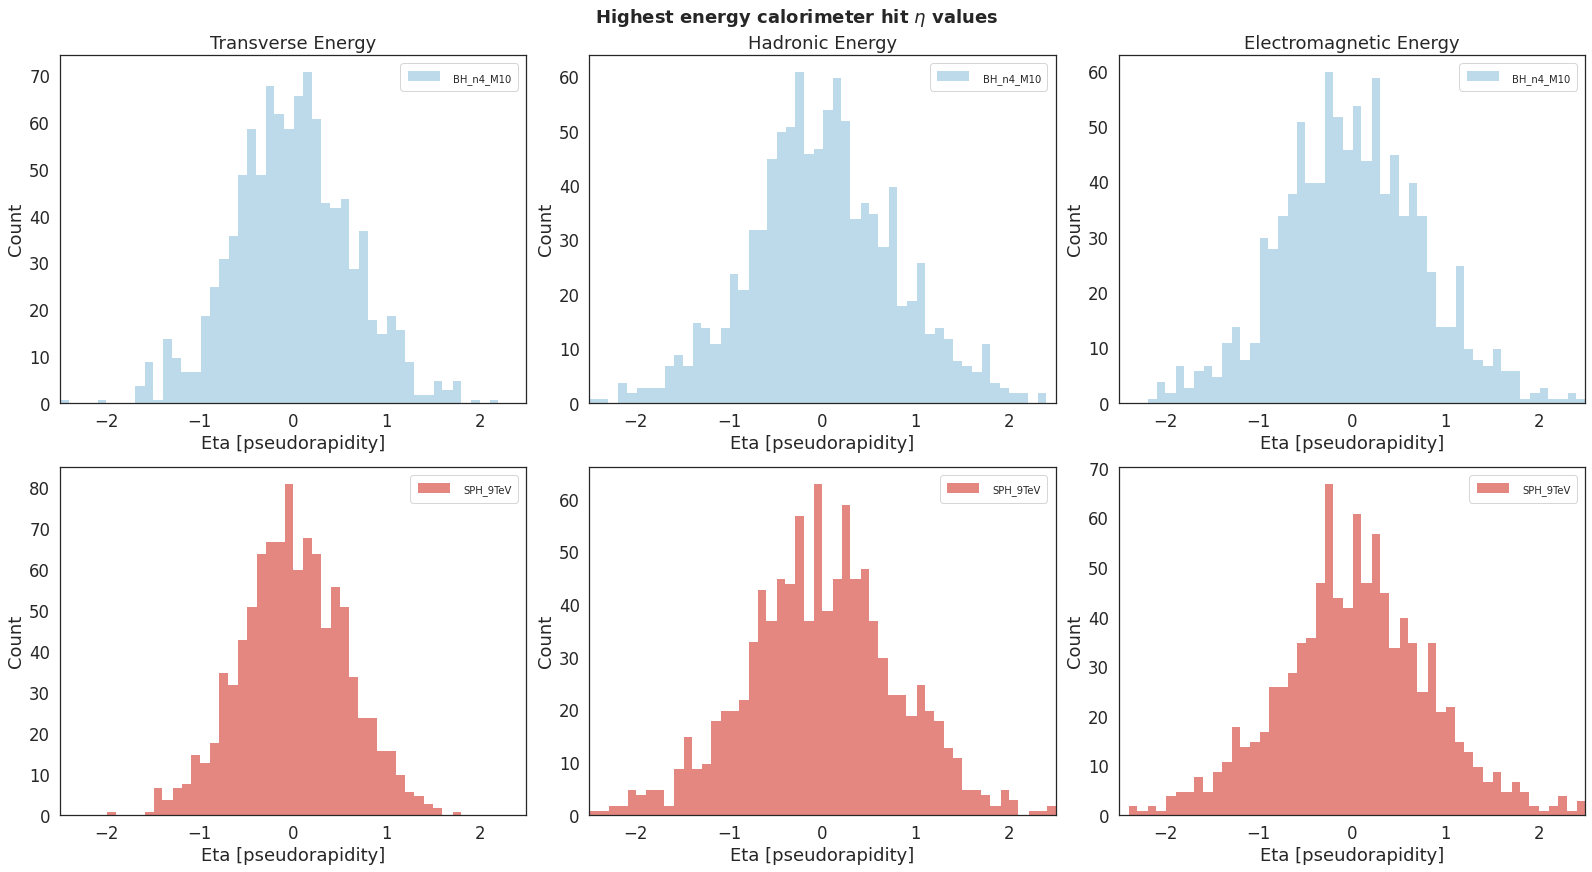

In [102]:
#Eta distribution
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(22,12), layout="constrained")
fig.suptitle(r"Highest energy calorimeter hit $\eta$ values", size=18, fontweight="bold")

sn.histplot(dict(zip(BH_labels, BH_cal["ET"][2])), ax = ax[0][0], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(sph_labels, sph_cal["ET"][2])), ax = ax[1][0], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][0].set_title("Transverse Energy")

sn.histplot(dict(zip(BH_labels, BH_cal["Ehad"][2])), ax = ax[0][1], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(sph_labels, sph_cal["Ehad"][2])), ax = ax[1][1], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][1].set_title("Hadronic Energy")

sn.histplot(dict(zip(BH_labels, BH_cal["Eem"][2])), ax = ax[0][2], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(sph_labels, sph_cal["Eem"][2])), ax = ax[1][2], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][2].set_title("Electromagnetic Energy")

for axis in ax.reshape(-1):
    axis.set_xlabel("Eta [pseudorapidity]")
    axis.set_xlim(-2.5, 2.5)
    plt.setp(axis.get_legend().get_texts(), fontsize='10')

print("STACKED histograms")

STACKED histograms


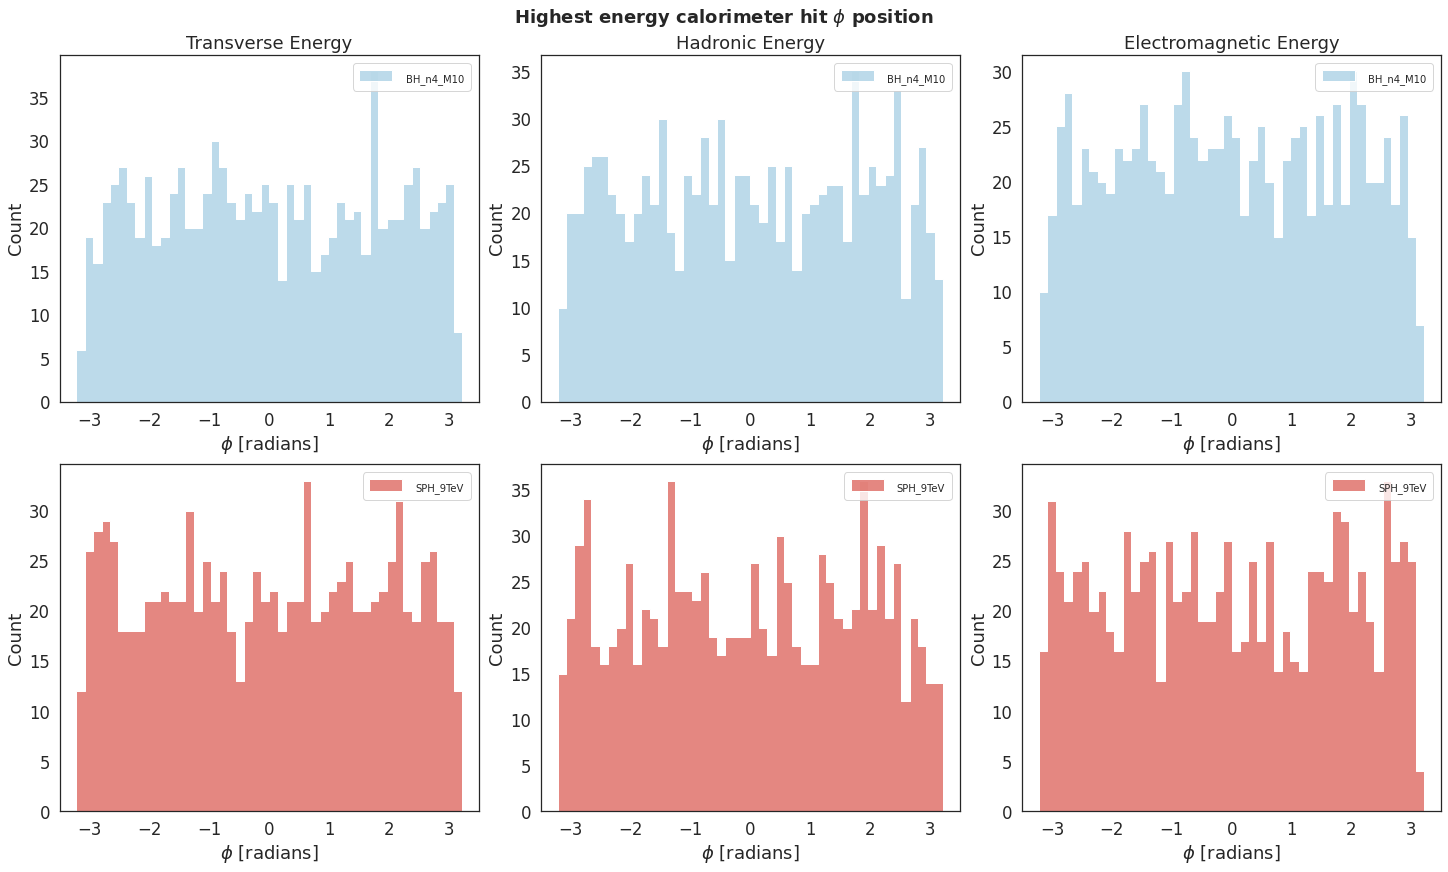

In [103]:
#Phi distribution, sanity check
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,12), layout="constrained")
fig.suptitle(r"Highest energy calorimeter hit $\phi$ position", size=18, fontweight="bold")

sn.histplot(dict(zip(BH_labels, BH_cal["ET"][1])), ax = ax[0][0], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(sph_labels, sph_cal["ET"][1])), ax = ax[1][0], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][0].set_title("Transverse Energy")

sn.histplot(dict(zip(BH_labels, BH_cal["Ehad"][1])), ax = ax[0][1], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(sph_labels, sph_cal["Ehad"][1])), ax = ax[1][1], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][1].set_title("Hadronic Energy")

sn.histplot(dict(zip(BH_labels, BH_cal["Eem"][1])), ax = ax[0][2], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(sph_labels, sph_cal["Eem"][1])), ax = ax[1][2], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][2].set_title("Electromagnetic Energy")

for axis in ax.reshape(-1):
    axis.set_xlabel(r"$\phi$ [radians]")
    axis.set_xlim(-3.5, 3.5)
    plt.setp(axis.get_legend().get_texts(), fontsize='10')

print("STACKED histograms")